In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime

In [1]:
romero_path = "/home/nromerodiaz93/Documents/Universidad/JI/Carlos/Parameters/Yo/depth_data.csv"

In [4]:
# Traemos los datos que hemos pre-procesado

data = pd.read_csv(romero_path)

In [3]:
data.head()

,date_time,nombre,date_time.1,tipo,precio,volumen,BID,ASK,Mid_Price,Quoted_Spread,dia,BID_depth,ASK_depth,Depth,log_depth
0,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,NaN,NaN,NaN,NaN,2017-03-03,0.0,0.0,0.0,0.000000
1,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,1305.0,1320.0,1312.5,0.011429,2017-03-03,100000.0,360000.0,460000.0,24.306785
2,2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,80000.0,180000.0,22.802707
3,2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,235240.0,335240.0,23.881287
4,2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,270000.0,235240.0,505240.0,24.874539


# Funciones
---
Comenzamos a definir las funciones necesarias para el análisis gráfico de los parámetros de calidad de mercado

In [4]:
# Funcion que calcula los dias habiles en Colombia

def business_days():
    # 2017
    weekmask = "Mon Tue Wed Thu Fri"
    holidays = [datetime.datetime(2017, 1, 9), datetime.datetime(2017, 3, 20), datetime.datetime(2017, 4, 13), 
                datetime.datetime(2017, 4, 14), datetime.datetime(2017, 5, 1), datetime.datetime(2017, 5, 29), 
                datetime.datetime(2017, 6, 19), datetime.datetime(2017, 6, 26), datetime.datetime(2017, 7, 3), 
                datetime.datetime(2017, 7, 20), datetime.datetime(2017, 8, 7), datetime.datetime(2017, 8, 21), 
                datetime.datetime(2017, 10, 16), datetime.datetime(2017, 11, 6), datetime.datetime(2017, 11, 13), 
                datetime.datetime(2017, 12, 8), datetime.datetime(2017, 12, 25)]

    BdaysCol2017 = pd.bdate_range(start = pd.datetime(2017, 1, 1), end = pd.datetime(2017, 12, 31), 
                                  freq = 'C',
                                  weekmask = weekmask, 
                                  holidays = holidays)
    
    return BdaysCol2017

In [5]:
a = business_days()
a

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=243, freq='C')

In [6]:
# Funcion que formatea los datos de un parametro para una accion

# Esta funcion retorna una matriz indexada por la hora en las filas y por
# dias en las columnas con los datos del parametro "param_name" en el dia 
# y hora correspondientes

def get_stock_param(stockdata, stockticker, param_name):
    
    stockdata = stockdata[stockdata.nombre == stockticker + " CB Equity"]
    
    idx = pd.to_datetime(stockdata.date_time)
    stockdata.index = idx
    stockdata.replace(0, np.nan, inplace=True)
    
    bus_days = business_days()
    
    # Log-depth
    if(param_name == "log_depth"):        
        
        depth15min = stockdata.log_depth.resample("15T").mean()
        depth15min = depth15min.between_time('9:30','15:45')
        
        depth15min = pd.DataFrame(depth15min)
        depth15min.columns = ["avg_log_depth"]
        depth15min = depth15min.reset_index()
        
        depth15min['date'] = pd.to_datetime(depth15min.date_time.dt.date)
        depth15min['time'] = depth15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        depth15minF = depth15min[depth15min.date.isin(bus_days)]
        
        # Quitamos columnas que ya no necesitamos
        depth15minF = depth15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        depth15minF = depth15minF.pivot_table(index=[depth15minF.date_time.dt.time, depth15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        depth15minF = depth15minF[depth15minF.sum(1)!=0]
        
        return depth15minF
    
    # Volatilidad
    elif(param_name == "Volatilidad"):
        x1 = stockdata[stockdata.tipo == "TRADE"]
        
        vol15max =  x1.precio.resample("15T").max()
        vol15min =  x1.precio.resample("15T").min()
        logmax   = np.log(vol15max)
        logmin   = np.log(vol15min)
        
        vola15min = ((logmax - logmin)**2)/(4*np.log(2)) 
        
        vola15min = vola15min.between_time('9:30','15:45')
        vola15min = vola15min.reset_index()
        
        vola15min['date'] = pd.to_datetime(vola15min.date_time.dt.date)
        vola15min['time'] = vola15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        vola15minF=vola15min[vola15min.date.isin(bus_days)]
        
        # Quitamos las columnas que ya no necesitamos
        vola15minF = vola15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        vola15minF = vola15minF.pivot_table(index=[vola15minF.date_time.dt.time, vola15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        vola15minF = vola15minF[vola15minF.sum(1)!=0]
        
        return vola15minF
    
    # Spread
    elif(param_name == "Spread"):
        spread15min = stockdata.Quoted_Spread.resample("15T").mean()
        spread15min = spread15min.between_time('9:30','15:45')
        spread15min = spread15min.reset_index()
        
        spread15min['date'] = pd.to_datetime(spread15min.date_time.dt.date)
        spread15min['time'] = spread15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        spread15minF = spread15min[spread15min.date.isin(bus_days)] 
        
        # Quitamos las columnas que ya no necesitamos
        spread15minF=spread15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        spread15minF = spread15minF.pivot_table(index=[spread15minF.date_time.dt.time, spread15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        spread15minF = spread15minF[spread15minF.sum(1)!=0]
        
        return spread15minF
    
    # Volumen
    elif(param_name == "Volumen"):
        x1 = stockdata[stockdata.tipo == "TRADE"]
        
        vol15min = x1.volumen.resample("15T").sum().fillna(value=0)
        vol15min = vol15min.reset_index()
        
        vol15min['date'] = pd.to_datetime(vol15min.date_time.dt.date)
        vol15min['time'] = vol15min.date_time.dt.time
        
        #select only business days colombia
        vol15minF=vol15min[vol15min.date.isin(bus_days)]
        
        # Quitamos las columnas que ya no necesitamos
        vol15minF=vol15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        vol15minF = vol15minF.pivot_table(index=[vol15minF.date_time.dt.time, vol15minF.date_time.dt.date]).unstack(1)
        
        # Tomamos el log-volumen
        vol15minP = np.log(vol15minF["volumen"] + 1)
        
        # Verificamos esta condicion que hizo Catalina
        vol15minP = vol15minP[vol15minP.sum(1) != 0]
        
        # Remover ceros
        vol15minP.replace(0.0, np.nan, inplace=True)
        
        return vol15minP

In [18]:
# Funcion que grafica los resultados

def graph(stockdata, stockticker, param_name):
    
    df = get_stock_param(stockdata, stockticker, param_name)
    xx = []
    yy = []
    
    cont = 0 #El contador sera nuestro eje x, pondremos las horas correspondientes sobre esto
    xxq  = []
    yy25 = []
    yy50 = []
    yy75 = []
    
    # Primer ciclo para recorrer las horas (filas) 
    for row in df.iterrows():
        cont += 1
        xxq.append(cont)
        
        yy25.append( np.nanpercentile(row[1].values, 25) )
        yy50.append( np.nanpercentile(row[1].values, 50) )
        yy75.append( np.nanpercentile(row[1].values, 75) )
        
        # Segundo ciclo para recorrer los dias (columnas)
        for i in range(len(row[1])):
            xx.append(cont)
            yy.append(row[1][i])
            
            
    xx = np.array(xx)
    yy = np.array(yy)
    xy = np.vstack([xx, yy])
    # La funcion stats.gaussian_kde() no acepta NaN, entonces aqui los reemplazo por cero 
    # despues de ya haber calculado los cuantiles
    xy[np.isnan(xy)] = 0.0    
    z  = stats.gaussian_kde(xy)(xy) # Este comando colorea los puntos

    idx = z.argsort() # Ordenamos los puntos para que queden los mas rojos encima de los azules
    xx, yy, z = xx[idx], yy[idx], z[idx]
    
    # Ticks eje x
    timelab = ('9:15','9:30','9:45','10:00','10:15','10:30','10:45','11:00', '11:15','11:30','11:45','12:00',
               '12:15','12:30','12:45','13:00','13:15', '13:30','13:45','14:00','14:15','14:30','14:45',
               '15:00','15:15','15:30','15:45','16:00')
    
    # Convertimos a array
    xxq  = np.array(xxq)
    yy25 = np.array(yy25)
    yy50 = np.array(yy50)
    yy75 = np.array(yy75)
    
    # Limites de la figura
    y_min = np.nanmin(yy)
    y_max = np.nanmax(yy)
    delta = 0.05*(y_max-y_min) # Ajuste para los ylim de la grafica
        
    # Grafica
    plt.figure(figsize=(17, 10))
    
    plt.scatter(xx, yy, c=z, s=100, edgecolor='') # Todos los datos
    plt.plot(xxq, yy25, linewidth = 1, c = "g")   # Cuantil 25
    plt.plot(xxq, yy50, linewidth = 2, c = "r")   # Cuantil 50
    plt.plot(xxq, yy75, linewidth = 1, c = "g")   # Cuantil 75
    
    # Titulo y ejes
    plt.title(param_name + " " + stockticker, fontsize=30)
    plt.xlabel("Hora",     fontsize = 20)
    plt.ylabel(param_name, fontsize=20)
    plt.xticks(np.arange(27), timelab, rotation=17)
    plt.colorbar()
    
    plt.ylim((y_min-delta, y_max+delta))
    plt.show()

# Aplicación
---
Evaluamos la función que formatea la matriz de datos

In [8]:
param_list = ["log_depth", "Volatilidad", "Spread", "Volumen"]

In [9]:
# Testeamos la funcion get_stock_param()

dep   = get_stock_param(data, "ECOPETL", param_list[0])
volat = get_stock_param(data, "ECOPETL", param_list[1])
spr   = get_stock_param(data, "ECOPETL", param_list[2])
volum = get_stock_param(data, "ECOPETL", param_list[3])

In [10]:
#volum[volum[volum.columns] != 0.0].tail()
volum.tail()

date_time,2017-03-03,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-13,2017-03-14,2017-03-15,2017-03-16,...,2017-08-17,2017-08-18,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,2017-08-29,2017-08-30,2017-08-31
date_time,,,,,,,,,,,,,,,,,,,,,
14:45:00,10.878066,8.824825,7.673688,9.927643,13.170647,12.220232,12.700147,7.902118,9.933920,13.474429,...,10.562690,9.409273,8.864040,8.011355,8.612685,12.382129,7.601402,8.641356,8.530899,8.684232
15:00:00,11.566210,11.888048,11.667662,NaN,12.138377,9.373054,12.616542,9.181015,13.254086,13.279124,...,7.714677,8.530504,10.238459,9.124674,8.030084,9.160625,12.830205,6.908755,11.318005,13.857773
15:15:00,11.866999,11.014753,11.514554,9.210440,12.698758,11.548022,11.854783,12.747632,13.032043,11.138872,...,8.071219,9.698552,9.680406,8.612685,12.598794,8.699681,12.531061,11.566476,9.996750,13.310858
15:30:00,9.439943,10.040071,10.798207,12.871954,13.644403,NaN,11.222587,9.713477,13.494441,11.690310,...,9.904087,8.353026,10.225317,12.000198,10.471043,9.529521,12.194744,10.646757,9.645364,14.084886
15:45:00,11.317373,12.862149,10.275086,12.424606,13.382073,13.199863,9.489940,13.780943,10.548809,14.579115,...,12.117394,9.434523,8.481773,10.193280,13.593349,14.149411,11.201756,12.936805,9.949225,13.236733


# Gráficas
---
Ensayamos la función que grafica los parámetros de calidad de mercado

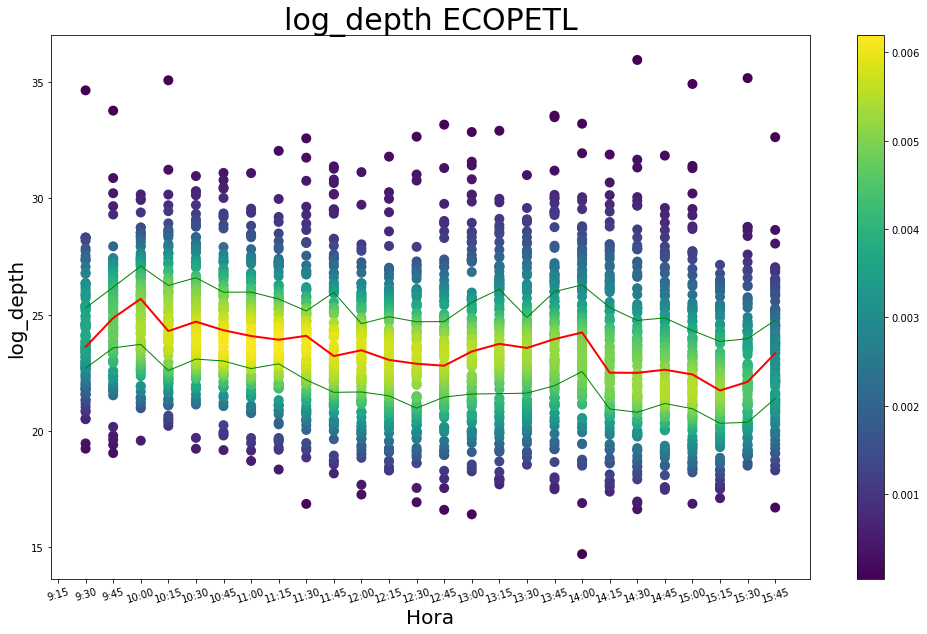

In [19]:
# Testeamos la funcion graph()

param_list = ["log_depth", "Volatilidad", "Spread", "Volumen"]
K = 0

graph(data, "ECOPETL", param_list[K])